<a href="https://colab.research.google.com/github/Leonel58/MACHINE_LEARNING_PYTHON/blob/master/analisis_data_zookeeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
zookeeper =  "/content/Zookeeper_2k.log"

In [1]:
import pandas as pd
import re
import numpy as np
from datetime import datetime

# Tu ruta
zookeeper_path = "/content/Zookeeper_2k.log"

# 1. Verificar que existe el archivo
import os
if os.path.exists(zookeeper_path):
    file_size = os.path.getsize(zookeeper_path)
    print(f"✅ Archivo encontrado: {zookeeper_path}")
    print(f"📊 Tamaño: {file_size / 1024:.2f} KB")
else:
    print("❌ Archivo no encontrado. Verifica la ruta.")

✅ Archivo encontrado: /content/Zookeeper_2k.log
📊 Tamaño: 273.33 KB


In [2]:
# Leer el archivo con diferentes encodings si es necesario
def read_log_file(filepath):
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']

    for encoding in encodings:
        try:
            with open(filepath, 'r', encoding=encoding) as f:
                lines = f.readlines()
            print(f"✅ Archivo leído con encoding: {encoding}")
            print(f"📄 Número total de líneas: {len(lines)}")
            return lines, encoding
        except UnicodeDecodeError as e:
            print(f"❌ Error con encoding {encoding}: {str(e)[:50]}...")
            continue

    # Si todos fallan, intentar modo binario
    print("⚠️  Intentando lectura binaria...")
    with open(filepath, 'rb') as f:
        content = f.read()
    # Decodificar ignorando errores
    lines = content.decode('utf-8', errors='ignore').splitlines()
    return lines, 'binary_fallback'

# Leer el archivo
log_lines, used_encoding = read_log_file(zookeeper_path)

# Mostrar primeras líneas para verificar
print("\n🔍 **PRIMERAS 5 LÍNEAS DEL ARCHIVO:**")
for i, line in enumerate(log_lines[:5]):
    print(f"Línea {i+1}: {line.strip()}")

✅ Archivo leído con encoding: utf-8
📄 Número total de líneas: 2000

🔍 **PRIMERAS 5 LÍNEAS DEL ARCHIVO:**
Línea 1: 2015-07-29 17:41:44,747 - INFO  [QuorumPeer[myid=1]/0:0:0:0:0:0:0:0:2181:FastLeaderElection@774] - Notification time out: 3200
Línea 2: 2015-07-29 19:04:12,394 - INFO  [/10.10.34.11:3888:QuorumCnxManager$Listener@493] - Received connection request /10.10.34.11:45307
Línea 3: 2015-07-29 19:04:29,071 - WARN  [SendWorker:188978561024:QuorumCnxManager$SendWorker@688] - Send worker leaving thread
Línea 4: 2015-07-29 19:04:29,079 - WARN  [SendWorker:188978561024:QuorumCnxManager$SendWorker@679] - Interrupted while waiting for message on queue
Línea 5: 2015-07-29 19:13:17,524 - WARN  [SendWorker:188978561024:QuorumCnxManager$SendWorker@688] - Send worker leaving thread


In [3]:
print("\n🔎 **ANÁLISIS DE ESTRUCTURA:**")

# Ver diferentes tipos de líneas
sample_lines = log_lines[:10]
patterns_to_check = [
    (r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}', 'Timestamp'),
    (r' - (INFO|WARN|ERROR|DEBUG) ', 'Nivel de log'),
    (r'\[.*?\]', 'Contexto entre corchetes'),
    (r'@\d+\]', 'Número de línea de código'),
]

for pattern, description in patterns_to_check:
    matches = sum(1 for line in sample_lines if re.search(pattern, line))
    print(f"{description}: {matches}/{len(sample_lines)} líneas")


🔎 **ANÁLISIS DE ESTRUCTURA:**
Timestamp: 10/10 líneas
Nivel de log: 10/10 líneas
Contexto entre corchetes: 10/10 líneas
Número de línea de código: 10/10 líneas


In [4]:
def parse_zookeeper_log_advanced(lines):
    """
    Parseo avanzado de logs de ZooKeeper
    """
    # Patrón principal para logs estructurados
    pattern1 = r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<log_level>\w+)\s+\[(?P<thread_component>[^\]]+):(?P<logger_class>[^@]+)@(?P<line_number>\d+)\] - (?P<message>.+)'

    # Patrón alternativo (para líneas con formato ligeramente diferente)
    pattern2 = r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<log_level>\w+)\s+\[(?P<thread_component>[^\]]+)\] - (?P<message>.+)'

    data = []
    unparsed_lines = []

    for i, line in enumerate(lines):
        line = line.strip()
        if not line:  # Saltar líneas vacías
            continue

        match1 = re.match(pattern1, line)
        match2 = re.match(pattern2, line)

        if match1:
            row = match1.groupdict()
            row['pattern_used'] = 'pattern1'
        elif match2:
            row = match2.groupdict()
            row['pattern_used'] = 'pattern2'
            # Agregar campos faltantes
            row['logger_class'] = None
            row['line_number'] = None
        else:
            unparsed_lines.append((i, line))
            continue

        # Extraer información adicional del mensaje
        message = row['message']

        # Extraer IPs
        ip_pattern = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
        ips = re.findall(ip_pattern, message)
        row['ips'] = ', '.join(ips) if ips else None

        # Extraer puertos
        port_pattern = r':(\d{4,5})'
        ports = re.findall(port_pattern, message)
        row['ports'] = ', '.join(ports) if ports else None

        # Extraer números (como timeouts)
        numbers = re.findall(r'\b(\d+)\b', message)
        row['numeric_values'] = ', '.join(numbers) if numbers else None

        # Clasificar tipo de evento
        message_lower = message.lower()
        if 'time out' in message_lower or 'timeout' in message_lower:
            row['event_category'] = 'Timeout'
        elif 'connection' in message_lower or 'connect' in message_lower:
            row['event_category'] = 'Connection'
        elif 'error' in message_lower:
            row['event_category'] = 'Error'
        elif 'warn' in message_lower:
            row['event_category'] = 'Warning'
        elif 'starting' in message_lower or 'started' in message_lower:
            row['event_category'] = 'Startup'
        elif 'shut' in message_lower or 'stop' in message_lower:
            row['event_category'] = 'Shutdown'
        else:
            row['event_category'] = 'Other'

        # Separar timestamp en fecha y hora
        ts = row['timestamp']
        date_part, time_part = ts.split(' ')
        row['date'] = date_part
        row['time'] = time_part
        row['hour'] = time_part.split(':')[0]  # Solo la hora

        data.append(row)

    # Crear DataFrame
    df = pd.DataFrame(data)

    # Informe de parseo
    print(f"\n📊 **INFORME DE PARSEO:**")
    print(f"Líneas totales procesadas: {len(lines)}")
    print(f"Líneas parseadas exitosamente: {len(df)}")
    print(f"Líneas no parseadas: {len(unparsed_lines)}")

    if unparsed_lines:
        print(f"\n⚠️  Primeras 3 líneas no parseadas:")
        for i, (line_num, line_text) in enumerate(unparsed_lines[:3]):
            print(f"  Línea {line_num}: {line_text[:80]}...")

    return df

# Parsear los logs
df = parse_zookeeper_log_advanced(log_lines)


📊 **INFORME DE PARSEO:**
Líneas totales procesadas: 2000
Líneas parseadas exitosamente: 1837
Líneas no parseadas: 163

⚠️  Primeras 3 líneas no parseadas:
  Línea 0: 2015-07-29 17:41:44,747 - INFO  [QuorumPeer[myid=1]/0:0:0:0:0:0:0:0:2181:FastLea...
  Línea 539: 2015-07-30 17:43:58,186 - INFO  [QuorumPeer[myid=1]/0:0:0:0:0:0:0:0:2181:Environ...
  Línea 541: 2015-07-30 17:55:26,200 - WARN  [WorkerSender[myid=1]:QuorumCnxManager@368] - Ca...


In [5]:
print("\n" + "="*60)
print("📋 **INFORMACIÓN DEL DATAFRAME**")
print("="*60)

# Información básica
print(f"📈 Forma del DataFrame: {df.shape}")
print(f"📝 Columnas disponibles: {list(df.columns)}")

# Mostrar primeras filas
print("\n🔍 **PRIMERAS 5 FILAS:**")
pd.set_option('display.max_columns', None)
print(df.head())

# Estadísticas básicas
print("\n📊 **ESTADÍSTICAS BÁSICAS:**")
print(f"Niveles de log: {df['log_level'].value_counts().to_dict()}")
print(f"Categorías de evento: {df['event_category'].value_counts().to_dict()}")

# Distribución temporal si hay datos
if 'date' in df.columns:
    print(f"\n📅 **DISTRIBUCIÓN TEMPORAL:**")
    print(f"Rango de fechas: {df['date'].min()} a {df['date'].max()}")
    print(f"Días únicos: {df['date'].nunique()}")


📋 **INFORMACIÓN DEL DATAFRAME**
📈 Forma del DataFrame: (1837, 14)
📝 Columnas disponibles: ['timestamp', 'log_level', 'thread_component', 'logger_class', 'line_number', 'message', 'pattern_used', 'ips', 'ports', 'numeric_values', 'event_category', 'date', 'time', 'hour']

🔍 **PRIMERAS 5 FILAS:**
                 timestamp log_level         thread_component  \
0  2015-07-29 19:04:12,394      INFO        /10.10.34.11:3888   
1  2015-07-29 19:04:29,071      WARN  SendWorker:188978561024   
2  2015-07-29 19:04:29,079      WARN  SendWorker:188978561024   
3  2015-07-29 19:13:17,524      WARN  SendWorker:188978561024   
4  2015-07-29 19:13:24,282      WARN  RecvWorker:188978561024   

                  logger_class line_number  \
0    QuorumCnxManager$Listener         493   
1  QuorumCnxManager$SendWorker         688   
2  QuorumCnxManager$SendWorker         679   
3  QuorumCnxManager$SendWorker         688   
4  QuorumCnxManager$RecvWorker         762   

                                   

In [6]:
# Guardar como CSV
csv_path = "/content/zookeeper_parsed.csv"
df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"\n💾 CSV guardado en: {csv_path}")

# Guardar como Excel (opcional, si necesitas)
try:
    excel_path = "/content/zookeeper_parsed.xlsx"
    df.to_excel(excel_path, index=False)
    print(f"📊 Excel guardado en: {excel_path}")
except Exception as e:
    print(f"⚠️  No se pudo guardar Excel: {e}")

# Guardar como JSON (para análisis web)
json_path = "/content/zookeeper_parsed.json"
df.to_json(json_path, orient='records', indent=2)
print(f"📄 JSON guardado en: {json_path}")


💾 CSV guardado en: /content/zookeeper_parsed.csv
📊 Excel guardado en: /content/zookeeper_parsed.xlsx
📄 JSON guardado en: /content/zookeeper_parsed.json


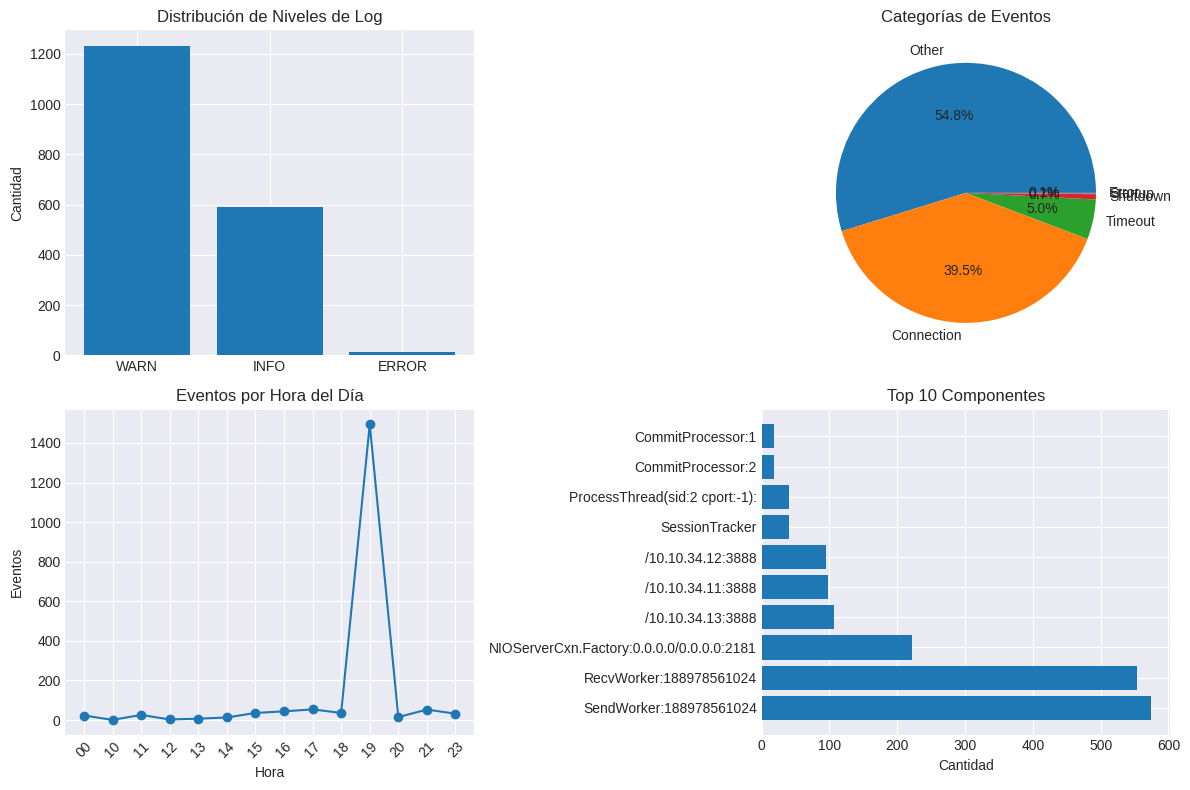


📈 Gráfico guardado en: /content/zookeeper_analysis.png


In [7]:
import matplotlib.pyplot as plt

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')

# Crear gráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Distribución de niveles de log
log_level_counts = df['log_level'].value_counts()
axes[0, 0].bar(log_level_counts.index, log_level_counts.values)
axes[0, 0].set_title('Distribución de Niveles de Log')
axes[0, 0].set_ylabel('Cantidad')

# 2. Distribución de categorías de evento
event_counts = df['event_category'].value_counts()
axes[0, 1].pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Categorías de Eventos')

# 3. Eventos por hora (si hay datos de hora)
if 'hour' in df.columns:
    hour_counts = df['hour'].value_counts().sort_index()
    axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o')
    axes[1, 0].set_title('Eventos por Hora del Día')
    axes[1, 0].set_xlabel('Hora')
    axes[1, 0].set_ylabel('Eventos')
    axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Top componentes
if 'thread_component' in df.columns:
    top_components = df['thread_component'].value_counts().head(10)
    axes[1, 1].barh(range(len(top_components)), top_components.values)
    axes[1, 1].set_yticks(range(len(top_components)))
    axes[1, 1].set_yticklabels(top_components.index)
    axes[1, 1].set_title('Top 10 Componentes')
    axes[1, 1].set_xlabel('Cantidad')

plt.tight_layout()
plt.savefig('/content/zookeeper_analysis.png', dpi=150)
plt.show()

print(f"\n📈 Gráfico guardado en: /content/zookeeper_analysis.png")

In [8]:
# Buscar problemas específicos
print("\n🔎 **BÚSQUEDA DE PATRONES CRÍTICOS:**")

# 1. Timeouts
timeouts = df[df['message'].str.contains('time out|timeout', case=False, na=False)]
print(f"⏰ Eventos de timeout encontrados: {len(timeouts)}")

# 2. Errores
errors = df[df['log_level'] == 'ERROR']
print(f"❌ Errores encontrados: {len(errors)}")

# 3. Conexiones fallidas
connection_issues = df[df['message'].str.contains('fail|error|exception|unable', case=False, na=False)]
print(f"🔌 Problemas de conexión: {len(connection_issues)}")

# 4. IPs más activas
if 'ips' in df.columns:
    all_ips = []
    for ip_str in df['ips'].dropna():
        all_ips.extend(ip_str.split(', '))

    if all_ips:
        from collections import Counter
        ip_counts = Counter(all_ips)
        print(f"\n🌐 IPs más frecuentes:")
        for ip, count in ip_counts.most_common(5):
            print(f"  {ip}: {count} ocurrencias")


🔎 **BÚSQUEDA DE PATRONES CRÍTICOS:**
⏰ Eventos de timeout encontrados: 91
❌ Errores encontrados: 13
🔌 Problemas de conexión: 345

🌐 IPs más frecuentes:
  10.10.34.11: 175 ocurrencias
  10.10.34.13: 147 ocurrencias
  10.10.34.12: 131 ocurrencias
  10.10.34.40: 7 ocurrencias
  10.10.34.18: 6 ocurrencias


In [9]:
from google.colab import files

# Descargar archivos procesados
files_to_download = [
    '/content/zookeeper_parsed.csv',
    '/content/zookeeper_parsed.json',
    '/content/zookeeper_analysis.png'
]

for file_path in files_to_download:
    if os.path.exists(file_path):
        files.download(file_path)
        print(f"⬇️  Descargado: {file_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  Descargado: /content/zookeeper_parsed.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  Descargado: /content/zookeeper_parsed.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  Descargado: /content/zookeeper_analysis.png


In [19]:
zookeeper_data = pd.read_csv("/content/zookeeper_parsed.csv")

In [22]:
zookeeper_data.head(5)

,timestamp,log_level,thread_component,logger_class,line_number,message,pattern_used,ips,ports,numeric_values,event_category,date,time,hour
0,"2015-07-29 19:04:12,394",INFO,/10.10.34.11:3888,QuorumCnxManager$Listener,493,Received connection request /10.10.34.11:45307,pattern1,10.10.34.11,45307.0,"10, 10, 34, 11, 45307",Connection,2015-07-29,"19:04:12,394",19
1,"2015-07-29 19:04:29,071",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,688,Send worker leaving thread,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:04:29,071",19
2,"2015-07-29 19:04:29,079",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,679,Interrupted while waiting for message on queue,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:04:29,079",19
3,"2015-07-29 19:13:17,524",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,688,Send worker leaving thread,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:13:17,524",19
4,"2015-07-29 19:13:24,282",WARN,RecvWorker:188978561024,QuorumCnxManager$RecvWorker,762,"Connection broken for id 188978561024, my id =...",pattern1,NaN,NaN,"188978561024, 1",Connection,2015-07-29,"19:13:24,282",19


In [15]:
zooper.describe()

,line_number,ports,hour
count,1837.000000,546.000000,1837.000000
mean,650.352205,48862.417582,18.481219
std,159.119166,7492.512543,2.582052
min,78.000000,3888.000000,0.000000
25%,493.000000,45166.250000,19.000000
50%,688.000000,48812.500000,19.000000
75%,762.000000,54647.500000,19.000000
max,1001.000000,60996.000000,23.000000


In [16]:
zooper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837 entries, 0 to 1836
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         1837 non-null   object 
 1   log_level         1837 non-null   object 
 2   thread_component  1837 non-null   object 
 3   logger_class      1837 non-null   object 
 4   line_number       1837 non-null   int64  
 5   message           1837 non-null   object 
 6   pattern_used      1837 non-null   object 
 7   ips               546 non-null    object 
 8   ports             546 non-null    float64
 9   numeric_values    848 non-null    object 
 10  event_category    1837 non-null   object 
 11  date              1837 non-null   object 
 12  time              1837 non-null   object 
 13  hour              1837 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 201.1+ KB


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
print("📊 CARGANDO DATOS...")
zookeeper_data = pd.read_csv("/content/zookeeper_parsed.csv")
print(f"✅ Dataset cargado: {zookeeper_data.shape[0]} filas × {zookeeper_data.shape[1]} columnas")

# Configurar estilo para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

📊 CARGANDO DATOS...
✅ Dataset cargado: 1837 filas × 14 columnas


In [24]:
print("\n" + "="*70)
print("🔍 **1. INFORMACIÓN GENERAL DEL DATAFRAME**")
print("="*70)

# Información detallada
print("\n📋 INFORMACIÓN DE COLUMNAS:")
print(zookeeper_data.info())

# Primeras y últimas filas
print("\n👀 PRIMERAS 5 FILAS:")
display(zookeeper_data.head())

print("\n👀 ÚLTIMAS 5 FILAS:")
display(zookeeper_data.tail())

# Estadísticas descriptivas para columnas numéricas
print("\n📈 ESTADÍSTICAS DESCRIPTIVAS (columnas numéricas):")
display(zookeeper_data.describe())

# Estadísticas para columnas categóricas
print("\n🔤 ESTADÍSTICAS PARA COLUMNAS CATEGÓRICAS:")
categorical_cols = zookeeper_data.select_dtypes(include=['object']).columns
for col in categorical_cols[:10]:  # Mostrar solo primeras 10 para no saturar
    print(f"\n{col}:")
    print(f"  Valores únicos: {zookeeper_data[col].nunique()}")
    print(f"  Top 5 valores: {zookeeper_data[col].value_counts().head().to_dict()}")


🔍 **1. INFORMACIÓN GENERAL DEL DATAFRAME**

📋 INFORMACIÓN DE COLUMNAS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837 entries, 0 to 1836
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         1837 non-null   object 
 1   log_level         1837 non-null   object 
 2   thread_component  1837 non-null   object 
 3   logger_class      1837 non-null   object 
 4   line_number       1837 non-null   int64  
 5   message           1837 non-null   object 
 6   pattern_used      1837 non-null   object 
 7   ips               546 non-null    object 
 8   ports             546 non-null    float64
 9   numeric_values    848 non-null    object 
 10  event_category    1837 non-null   object 
 11  date              1837 non-null   object 
 12  time              1837 non-null   object 
 13  hour              1837 non-null   int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 201.1+ KB
None

,timestamp,log_level,thread_component,logger_class,line_number,message,pattern_used,ips,ports,numeric_values,event_category,date,time,hour
0,"2015-07-29 19:04:12,394",INFO,/10.10.34.11:3888,QuorumCnxManager$Listener,493,Received connection request /10.10.34.11:45307,pattern1,10.10.34.11,45307.0,"10, 10, 34, 11, 45307",Connection,2015-07-29,"19:04:12,394",19
1,"2015-07-29 19:04:29,071",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,688,Send worker leaving thread,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:04:29,071",19
2,"2015-07-29 19:04:29,079",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,679,Interrupted while waiting for message on queue,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:04:29,079",19
3,"2015-07-29 19:13:17,524",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,688,Send worker leaving thread,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:13:17,524",19
4,"2015-07-29 19:13:24,282",WARN,RecvWorker:188978561024,QuorumCnxManager$RecvWorker,762,"Connection broken for id 188978561024, my id =...",pattern1,NaN,NaN,"188978561024, 1",Connection,2015-07-29,"19:13:24,282",19



👀 ÚLTIMAS 5 FILAS:


,timestamp,log_level,thread_component,logger_class,line_number,message,pattern_used,ips,ports,numeric_values,event_category,date,time,hour
1832,"2015-08-10 17:52:39,698",INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181,ZooKeeperServer,839,Client attempting to establish new session at ...,pattern1,10.10.34.13,58180.0,"10, 10, 34, 13, 58180",Other,2015-08-10,"17:52:39,698",17
1833,"2015-08-10 17:53:14,914",INFO,NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181,NIOServerCnxn,1001,Closed socket connection for client /10.10.34....,pattern1,10.10.34.12,33342.0,"10, 10, 34, 12, 33342",Connection,2015-08-10,"17:53:14,914",17
1834,"2015-08-10 17:53:16,001",INFO,SessionTracker,ZooKeeperServer,325,"Expiring session 0x14f05578bd80006, timeout of...",pattern1,NaN,NaN,NaN,Timeout,2015-08-10,"17:53:16,001",17
1835,"2015-08-10 18:12:34,001",INFO,SessionTracker,ZooKeeperServer,325,"Expiring session 0x14f05578bd8000f, timeout of...",pattern1,NaN,NaN,NaN,Timeout,2015-08-10,"18:12:34,001",18
1836,"2015-08-10 18:12:34,004",INFO,ProcessThread(sid:3 cport:-1):,PrepRequestProcessor,476,Processed session termination for sessionid: 0...,pattern1,NaN,NaN,NaN,Other,2015-08-10,"18:12:34,004",18



📈 ESTADÍSTICAS DESCRIPTIVAS (columnas numéricas):


,line_number,ports,hour
count,1837.000000,546.000000,1837.000000
mean,650.352205,48862.417582,18.481219
std,159.119166,7492.512543,2.582052
min,78.000000,3888.000000,0.000000
25%,493.000000,45166.250000,19.000000
50%,688.000000,48812.500000,19.000000
75%,762.000000,54647.500000,19.000000
max,1001.000000,60996.000000,23.000000



🔤 ESTADÍSTICAS PARA COLUMNAS CATEGÓRICAS:

timestamp:
  Valores únicos: 1780
  Top 5 valores: {'2015-08-20 17:14:24,000': 3, '2015-07-29 19:30:42,315': 2, '2015-07-29 19:26:48,698': 2, '2015-07-29 19:30:50,712': 2, '2015-07-29 19:04:30,989': 2}

log_level:
  Valores únicos: 3
  Top 5 valores: {'WARN': 1232, 'INFO': 592, 'ERROR': 13}

thread_component:
  Valores únicos: 54
  Top 5 valores: {'SendWorker:188978561024': 574, 'RecvWorker:188978561024': 554, 'NIOServerCxn.Factory:0.0.0.0/0.0.0.0:2181': 222, '/10.10.34.13:3888': 106, '/10.10.34.11:3888': 98}

logger_class:
  Valores únicos: 14
  Top 5 valores: {'QuorumCnxManager$SendWorker': 576, 'QuorumCnxManager$RecvWorker': 557, 'QuorumCnxManager$Listener': 300, 'ZooKeeperServer': 171, 'NIOServerCnxn': 89}

message:
  Valores únicos: 659
  Top 5 valores: {'Interrupted while waiting for message on queue': 314, 'Interrupting SendWorker': 266, 'Send worker leaving thread': 262, 'Connection broken for id 188978561024, my id = 3, error =': 99,


❓ **2. ANÁLISIS DE VALORES NULOS Y VACÍOS**

📊 VALORES NULOS POR COLUMNA:


,Valores_Nulos,Porcentaje_Nulos,Tipo_Dato
ips,1291,70.28,object
ports,1291,70.28,float64
numeric_values,989,53.84,object



📊 VALORES VACÍOS (strings ''):
✅ No hay valores de cadena vacíos ('')

📊 VALORES 'None' O 'NaN' COMO STRINGS:


,Columna,Valores_None_NaN
0,ips,1291
1,numeric_values,989


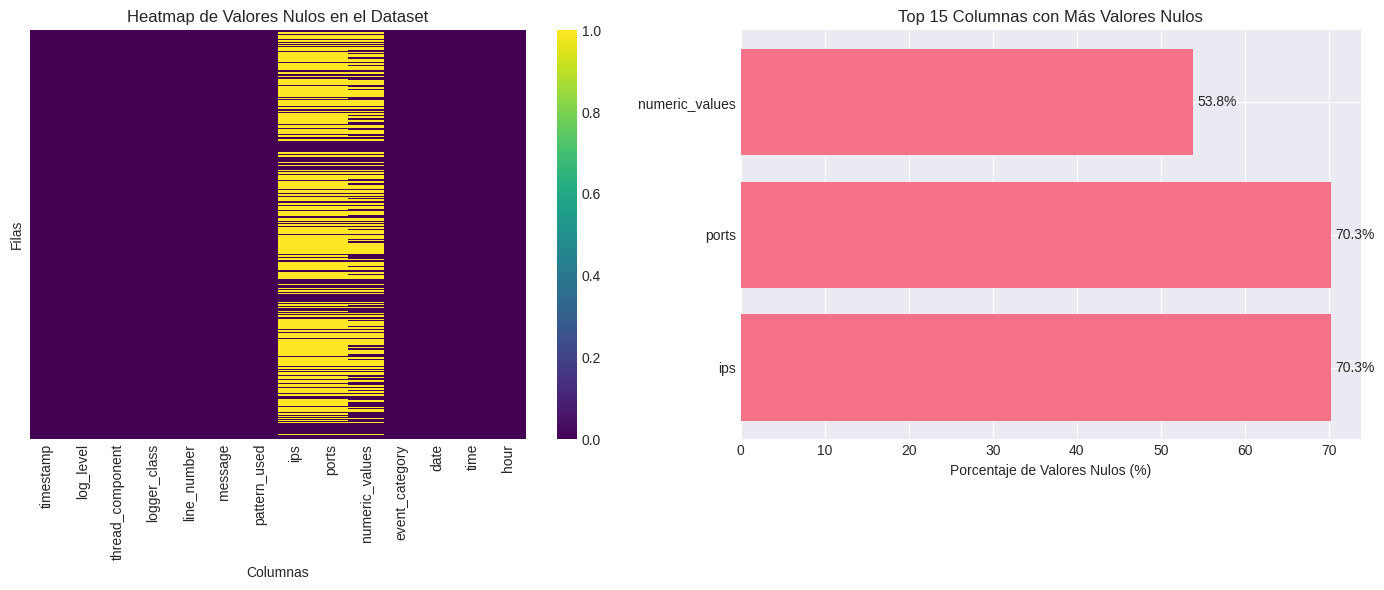

In [25]:
print("\n" + "="*70)
print("❓ **2. ANÁLISIS DE VALORES NULOS Y VACÍOS**")
print("="*70)

# 2.1 Valores nulos por columna
null_counts = zookeeper_data.isnull().sum()
null_percentage = (null_counts / len(zookeeper_data)) * 100

print("\n📊 VALORES NULOS POR COLUMNA:")
null_summary = pd.DataFrame({
    'Valores_Nulos': null_counts,
    'Porcentaje_Nulos': null_percentage.round(2),
    'Tipo_Dato': zookeeper_data.dtypes
})
display(null_summary[null_summary['Valores_Nulos'] > 0].sort_values('Porcentaje_Nulos', ascending=False))

# 2.2 Valores vacíos (strings vacíos)
print("\n📊 VALORES VACÍOS (strings ''):")
empty_counts = {}
for col in zookeeper_data.select_dtypes(include=['object']).columns:
    empty_count = (zookeeper_data[col] == '').sum()
    if empty_count > 0:
        empty_counts[col] = empty_count

if empty_counts:
    empty_df = pd.DataFrame(list(empty_counts.items()), columns=['Columna', 'Valores_Vacios'])
    empty_df['Porcentaje'] = (empty_df['Valores_Vacios'] / len(zookeeper_data) * 100).round(2)
    display(empty_df)
else:
    print("✅ No hay valores de cadena vacíos ('')")

# 2.3 Valores "None" o "NaN" como strings
print("\n📊 VALORES 'None' O 'NaN' COMO STRINGS:")
none_like_counts = {}
for col in zookeeper_data.select_dtypes(include=['object']).columns:
    none_count = zookeeper_data[col].astype(str).str.lower().isin(['none', 'nan', 'null', 'na']).sum()
    if none_count > 0:
        none_like_counts[col] = none_count

if none_like_counts:
    none_df = pd.DataFrame(list(none_like_counts.items()), columns=['Columna', 'Valores_None_NaN'])
    display(none_df)
else:
    print("✅ No hay valores 'None' o 'NaN' como strings")

# 2.4 Visualización de valores nulos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Heatmap de valores nulos
sns.heatmap(zookeeper_data.isnull(),
            yticklabels=False,
            cbar=True,
            cmap='viridis',
            ax=axes[0])
axes[0].set_title('Heatmap de Valores Nulos en el Dataset')
axes[0].set_xlabel('Columnas')
axes[0].set_ylabel('Filas')

# Gráfico 2: Porcentaje de nulos por columna
null_data = null_summary[null_summary['Valores_Nulos'] > 0].sort_values('Porcentaje_Nulos', ascending=False)
if not null_data.empty:
    bars = axes[1].barh(null_data.index[:15], null_data['Porcentaje_Nulos'][:15])
    axes[1].set_xlabel('Porcentaje de Valores Nulos (%)')
    axes[1].set_title('Top 15 Columnas con Más Valores Nulos')
    # Agregar etiquetas de valor
    for bar in bars:
        width = bar.get_width()
        axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center')
else:
    axes[1].text(0.5, 0.5, '✅ No hay valores nulos',
                ha='center', va='center', fontsize=12)
    axes[1].set_title('No hay valores nulos')

plt.tight_layout()
plt.show()


🔍 **3. ANÁLISIS DE DATOS DUPLICADOS**

📊 Duplicados exactos (todas las columnas iguales): 1
   Porcentaje: 0.05%

🔍 Ejemplo de filas duplicadas:


,timestamp,log_level,thread_component,logger_class,line_number,message,pattern_used,ips,ports,numeric_values,event_category,date,time,hour
409,"2015-07-29 19:34:15,884",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,688,Send worker leaving thread,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:34:15,884",19
410,"2015-07-29 19:34:15,884",WARN,SendWorker:188978561024,QuorumCnxManager$SendWorker,688,Send worker leaving thread,pattern1,NaN,NaN,NaN,Other,2015-07-29,"19:34:15,884",19



📊 DUPLICADOS EN COLUMNAS CLAVE:
  Opción 1 (timestamp): 57 duplicados
  Opción 2 (timestamp, message): 1 duplicados
  Opción 3 (date, time, thread_component): 22 duplicados

📈 ANÁLISIS DE FRECUENCIA DE DUPLICADOS:
  Combinaciones únicas que se repiten: 0
  Máximo de repeticiones: nan
  Promedio de repeticiones: nan


IndexError: index 0 is out of bounds for axis 0 with size 0

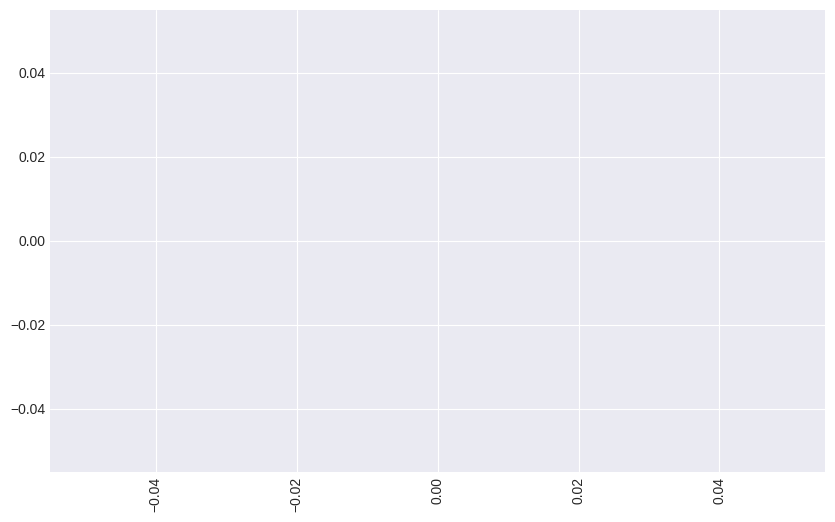

In [26]:
print("\n" + "="*70)
print("🔍 **3. ANÁLISIS DE DATOS DUPLICADOS**")
print("="*70)

# 3.1 Duplicados exactos en todas las columnas
exact_duplicates = zookeeper_data.duplicated().sum()
print(f"\n📊 Duplicados exactos (todas las columnas iguales): {exact_duplicates}")
print(f"   Porcentaje: {(exact_duplicates / len(zookeeper_data) * 100):.2f}%")

if exact_duplicates > 0:
    print("\n🔍 Ejemplo de filas duplicadas:")
    duplicated_rows = zookeeper_data[zookeeper_data.duplicated(keep=False)]
    display(duplicated_rows.head(10))

# 3.2 Duplicados en columnas clave (ajusta según tu dataset)
print("\n📊 DUPLICADOS EN COLUMNAS CLAVE:")

# Columnas que deberían ser únicas (ajustar según contexto)
key_columns_options = [
    ['timestamp'],  # Timestamps deberían ser únicos
    ['timestamp', 'message'],  # Combinación timestamp + mensaje
    ['date', 'time', 'thread_component'],  # Combinación temporal + componente
]

for i, cols in enumerate(key_columns_options):
    # Verificar que las columnas existan en el dataset
    existing_cols = [col for col in cols if col in zookeeper_data.columns]
    if existing_cols:
        duplicates = zookeeper_data.duplicated(subset=existing_cols).sum()
        print(f"  Opción {i+1} ({', '.join(existing_cols)}): {duplicates} duplicados")

# 3.3 Frecuencia de duplicación
if exact_duplicates > 0:
    print("\n📈 ANÁLISIS DE FRECUENCIA DE DUPLICADOS:")
    duplicate_counts = zookeeper_data.groupby(zookeeper_data.columns.tolist()).size().reset_index(name='count')
    duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

    print(f"  Combinaciones únicas que se repiten: {len(duplicate_counts)}")
    print(f"  Máximo de repeticiones: {duplicate_counts['count'].max()}")
    print(f"  Promedio de repeticiones: {duplicate_counts['count'].mean():.2f}")

    # Visualización
    fig, ax = plt.subplots(figsize=(10, 6))
    duplicate_counts['count'].value_counts().sort_index().plot(kind='bar', ax=ax)
    ax.set_xlabel('Número de Repeticiones')
    ax.set_ylabel('Frecuencia')
    ax.set_title('Distribución de Frecuencia de Duplicados')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
print("\n" + "="*70)
print("✅ **4. ANÁLISIS DE CONSISTENCIA DE DATOS**")
print("="*70)

# 4.1 Valores únicos por columna
print("\n🔢 VALORES ÚNICOS POR COLUMNA:")
unique_counts = {}
for col in zookeeper_data.columns:
    unique_counts[col] = zookeeper_data[col].nunique()

unique_df = pd.DataFrame(list(unique_counts.items()), columns=['Columna', 'Valores_Únicos'])
unique_df['Porcentaje_Único'] = (unique_df['Valores_Únicos'] / len(zookeeper_data) * 100).round(2)
display(unique_df.sort_values('Valores_Únicos', ascending=False))

# 4.2 Verificar formatos de columnas específicas
print("\n📝 VERIFICACIÓN DE FORMATOS:")

# Timestamp
if 'timestamp' in zookeeper_data.columns:
    print("\n⏰ COLUMNA 'timestamp':")
    # Verificar si todos siguen el formato esperado
    timestamp_pattern = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}'
    valid_timestamps = zookeeper_data['timestamp'].astype(str).str.match(timestamp_pattern).sum()
    print(f"  Timestamps con formato válido: {valid_timestamps}/{len(zookeeper_data)}")

    # Intentar convertir a datetime
    try:
        zookeeper_data['timestamp_dt'] = pd.to_datetime(zookeeper_data['timestamp'], format='%Y-%m-%d %H:%M:%S,%f')
        print("  ✅ Conversión a datetime exitosa")
    except Exception as e:
        print(f"  ❌ Error en conversión: {e}")

# log_level
if 'log_level' in zookeeper_data.columns:
    print("\n📊 COLUMNA 'log_level':")
    valid_levels = ['INFO', 'WARN', 'ERROR', 'DEBUG', 'TRACE']
    invalid_levels = set(zookeeper_data['log_level'].unique()) - set(valid_levels)
    print(f"  Niveles válidos encontrados: {set(zookeeper_data['log_level'].unique()) & set(valid_levels)}")
    if invalid_levels:
        print(f"  ⚠️  Niveles no estándar: {invalid_levels}")

# 4.3 Análisis de outliers en columnas numéricas
print("\n📏 ANÁLISIS DE OUTLIERS (valores atípicos):")
numeric_cols = zookeeper_data.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 0:
    for col in numeric_cols:
        q1 = zookeeper_data[col].quantile(0.25)
        q3 = zookeeper_data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = zookeeper_data[(zookeeper_data[col] < lower_bound) | (zookeeper_data[col] > upper_bound)]
        if len(outliers) > 0:
            print(f"  {col}: {len(outliers)} outliers ({len(outliers)/len(zookeeper_data)*100:.2f}%)")
else:
    print("  No hay columnas numéricas para análisis de outliers")


📋 **5. RESUMEN GENERAL DE CALIDAD DE DATOS**


,Métrica,Valor,Interpretación
0,Completitud,86.11%,⚠️ Aceptable
1,Duplicados exactos,0.05%,✅ Excelente
2,Consistencia (log_level),100.00%,✅ Excelente
3,Columnas con >50% nulos,3,⚠️ 3 columnas problemáticas


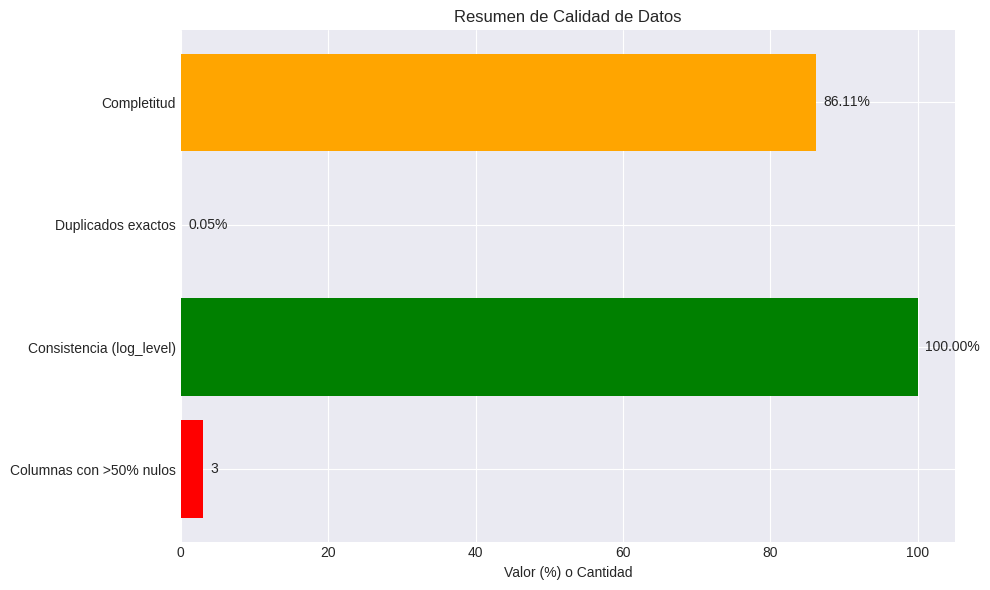

In [27]:
print("\n" + "="*70)
print("📋 **5. RESUMEN GENERAL DE CALIDAD DE DATOS**")
print("="*70)

# Crear resumen
quality_summary = []

# 1. Completitud
total_cells = zookeeper_data.shape[0] * zookeeper_data.shape[1]
null_cells = zookeeper_data.isnull().sum().sum()
completitud = ((total_cells - null_cells) / total_cells * 100)

quality_summary.append({
    'Métrica': 'Completitud',
    'Valor': f"{completitud:.2f}%",
    'Interpretación': '✅ Excelente' if completitud > 95 else '⚠️  Aceptable' if completitud > 80 else '❌ Necesita limpieza'
})

# 2. Duplicados
dup_percentage = (exact_duplicates / len(zookeeper_data) * 100)
quality_summary.append({
    'Métrica': 'Duplicados exactos',
    'Valor': f"{dup_percentage:.2f}%",
    'Interpretación': '✅ Excelente' if dup_percentage < 1 else '⚠️  Aceptable' if dup_percentage < 5 else '❌ Necesita limpieza'
})

# 3. Consistencia (log_level como ejemplo)
if 'log_level' in zookeeper_data.columns:
    valid_logs = zookeeper_data['log_level'].isin(['INFO', 'WARN', 'ERROR', 'DEBUG', 'TRACE']).sum()
    consistency = (valid_logs / len(zookeeper_data) * 100)
    quality_summary.append({
        'Métrica': 'Consistencia (log_level)',
        'Valor': f"{consistency:.2f}%",
        'Interpretación': '✅ Excelente' if consistency > 99 else '⚠️  Aceptable' if consistency > 95 else '❌ Problemas'
    })

# 4. Columnas con muchos nulos
high_null_cols = null_summary[null_summary['Porcentaje_Nulos'] > 50].shape[0]
quality_summary.append({
    'Métrica': 'Columnas con >50% nulos',
    'Valor': str(high_null_cols),
    'Interpretación': '✅ Bueno' if high_null_cols == 0 else f'⚠️  {high_null_cols} columnas problemáticas'
})

# Mostrar resumen
summary_df = pd.DataFrame(quality_summary)
display(summary_df)

# Gráfico de resumen
fig, ax = plt.subplots(figsize=(10, 6))
metrics = summary_df['Métrica']
values = []
colors = []

for idx, row in summary_df.iterrows():
    if 'Excelente' in row['Interpretación']:
        colors.append('green')
    elif 'Aceptable' in row['Interpretación'] or 'Bueno' in row['Interpretación']:
        colors.append('orange')
    else:
        colors.append('red')

    # Extraer valor numérico
    val_str = row['Valor'].replace('%', '')
    try:
        values.append(float(val_str))
    except:
        values.append(0)

bars = ax.barh(metrics, values, color=colors)
ax.set_xlabel('Valor (%) o Cantidad')
ax.set_title('Resumen de Calidad de Datos')
ax.invert_yaxis()

# Agregar etiquetas
for bar, val in zip(bars, summary_df['Valor']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            val, ha='left', va='center')

plt.tight_layout()
plt.show()

In [28]:
print("\n" + "="*70)
print("🧹 **6. RECOMENDACIONES DE LIMPIEZA**")
print("="*70)

print("\n🔧 ACCIONES SUGERIDAS BASADAS EN EL ANÁLISIS:\n")

# 1. Para valores nulos
high_null_cols = null_summary[null_summary['Porcentaje_Nulos'] > 20].index.tolist()
if high_null_cols:
    print(f"1. COLUMNAS CON MÁS DEL 20% DE VALORES NULOS:")
    for col in high_null_cols:
        null_pct = null_summary.loc[col, 'Porcentaje_Nulos']
        print(f"   - '{col}': {null_pct}% nulos")
        if null_pct > 80:
            print(f"     → RECOMENDACIÓN: Eliminar columna")
        elif null_pct > 50:
            print(f"     → RECOMENDACIÓN: Considerar eliminar o imputar con 'DESCONOCIDO'")
        else:
            print(f"     → RECOMENDACIÓN: Imputar con valor más frecuente o específico")

# 2. Para duplicados
if exact_duplicates > 0:
    print(f"\n2. DUPLICADOS EXACTOS: {exact_duplicates} filas")
    print(f"   → RECOMENDACIÓN: {'Eliminar duplicados' if dup_percentage < 10 else 'Investigar causa de duplicación antes de eliminar'}")

# 3. Para valores vacíos/inconsistentes
if empty_counts or none_like_counts:
    print(f"\n3. VALORES VACÍOS O INCONSISTENTES:")
    if empty_counts:
        print(f"   - Strings vacíos en: {list(empty_counts.keys())}")
    if none_like_counts:
        print(f"   - Strings 'None/NaN' en: {list(none_like_counts.keys())}")
    print(f"   → RECOMENDACIÓN: Reemplazar con np.nan para consistencia")

# 4. Para formato de datos
print(f"\n4. FORMATO DE DATOS:")
if 'timestamp' in zookeeper_data.columns:
    print(f"   - Convertir 'timestamp' a tipo datetime para análisis temporal")
if 'log_level' in zookeeper_data.columns and invalid_levels:
    print(f"   - Estandarizar niveles de log: {invalid_levels} → categorías válidas")

# 5. Columnas para eliminar/revisar
print(f"\n5. COLUMNAS PARA REVISAR:")
low_variance_cols = unique_df[unique_df['Porcentaje_Único'] < 1]['Columna'].tolist()
if low_variance_cols:
    print(f"   - Columnas con poca variabilidad (<1% único): {low_variance_cols[:5]}...")
    print(f"     → Considerar eliminar si no aportan información")

print("\n" + "="*70)
print("📝 **PLAN DE LIMPIEZA SUGERIDO:**")
print("="*70)
print("""
1. Eliminar columnas con >80% de valores nulos
2. Eliminar duplicados exactos (si el porcentaje es bajo)
3. Convertir 'timestamp' a datetime
4. Estandarizar 'log_level' si hay valores inconsistentes
5. Reemplazar strings vacíos y 'None' con np.nan
6. Considerar eliminar columnas con poca variabilidad
7. Guardar dataset limpio en nuevo archivo
""")


🧹 **6. RECOMENDACIONES DE LIMPIEZA**

🔧 ACCIONES SUGERIDAS BASADAS EN EL ANÁLISIS:

1. COLUMNAS CON MÁS DEL 20% DE VALORES NULOS:
   - 'ips': 70.28% nulos
     → RECOMENDACIÓN: Considerar eliminar o imputar con 'DESCONOCIDO'
   - 'ports': 70.28% nulos
     → RECOMENDACIÓN: Considerar eliminar o imputar con 'DESCONOCIDO'
   - 'numeric_values': 53.84% nulos
     → RECOMENDACIÓN: Considerar eliminar o imputar con 'DESCONOCIDO'

2. DUPLICADOS EXACTOS: 1 filas
   → RECOMENDACIÓN: Eliminar duplicados

3. VALORES VACÍOS O INCONSISTENTES:
   - Strings 'None/NaN' en: ['ips', 'numeric_values']
   → RECOMENDACIÓN: Reemplazar con np.nan para consistencia

4. FORMATO DE DATOS:
   - Convertir 'timestamp' a tipo datetime para análisis temporal


NameError: name 'invalid_levels' is not defined